# Selecting ROIs on the MEG helmet (4D 248 channel system).

In [1]:
import os.path as op
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mne
import seaborn as sns

In [2]:
sns.set(style='ticks', palette='Set2')
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

In [3]:
mne.utils.set_log_level('warning')

In [4]:
df = pd.read_csv('unrelated_MEG_subjects.csv')
subjects_missing = pd.read_csv('missing_freesurfer_s900_unrelated.csv').SubjectId.tolist()
subjects = [str(sub) for sub in df.Subject.tolist() if sub not in subjects_missing]

In [5]:
with open('unrelated_subjects.txt', 'w') as fid:
    fid.write('\n'.join(subjects))

In [ ]:
# %%bash
# rm download_output.txt
# for sub in $(cat unrelated_subjects.txt)
# do
#     echo "downloading epochs for ${sub}" 
#     python hcp_compute_subject.py --storage_dir /mnt --hcp_no_anat --hcp_no_meg \
#     --subject $sub --downloaders "library:downloaders.get_single_trial_psd";
# done &> download_output.txt

In [6]:
recordings_path = '/mnt/hcp-meg'
pattern = 'psds-r{run}-0-150-epo.fif'

def get_epochs_for_subject(subject):
    epochs_list = list()
    for run_index in range(3):
        psd_fname = op.join(recordings_path, subject, pattern.format(run=run_index))
        if op.isfile(psd_fname):
            epochs = mne.read_epochs(psd_fname)
            epochs.events[:, 2].fill(run_index)
            epochs.event_id = {'run%d' % run_index: run_index}
            if epochs.info['nchan'] == 248:
                epochs_list.append(epochs)
    if epochs_list:
        epochs = mne.epochs.concatenate_epochs(epochs_list)
    else:
        epochs = None
    return epochs

epochs = get_epochs_for_subject(subjects[1])

In [7]:
rois = dict(
    central=[(1, 36), (39, 59)],
    frontal=[(118, 124), (150, 152), (87, 92), (37, 38), (60, 63)],
    frontal_inner_left=[(125, 131), (93, 99), (64, 70)],
    frontal_outer_left=[(229, 233), (212, 214), (196, 198), (177, 180), (153, 158)],
    frontal_inner_right=[(80, 86), (111, 117), (143, 149)],
    frontal_outer_right=[(171, 176), (192, 195), (209, 211), (226, 228), (244, 248)],
    parietal_left=[(159, 163), (132, 135), (100, 103), (71, 73)],
    parietal_center=[(74, 76), (104, 106), (136, 138), (164, 165)],
    parietal_right=[(77, 79), (107, 110), (139, 142), (166, 170)],
    temporal_left=[(234, 236), (215, 218), (199, 202), (181, 185)],
    temporal_right=[(187, 191), (205, 208), (222, 225), (241, 243)],
    occiptial=[(237, 240), (219, 221), (203, 204), (186, 186)]
)
for key, values in rois.items():
    values_ = [tuple(sorted(vals)) for vals in values]
    selection_int = sum([range(start, stop + 1, 1) for start, stop in values_], [])
    rois[key] = ['A%d' % ii for ii in sorted(selection_int)]

assert list(sorted(sum(rois.values(), []))) == list(sorted(epochs.ch_names))

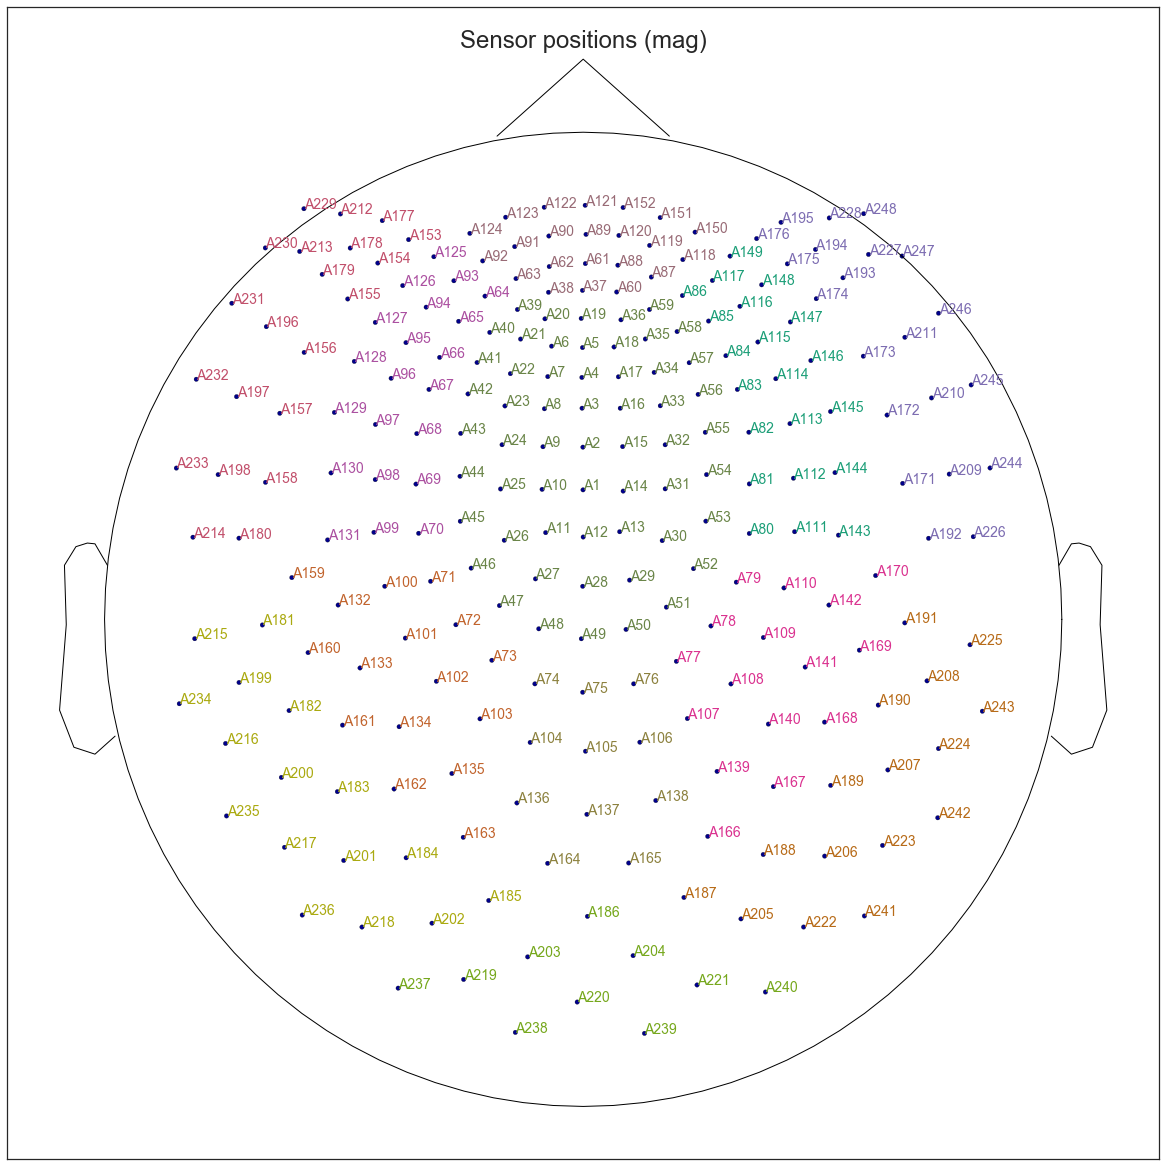

In [11]:
%matplotlib inline

width = 2
sns.set_context("paper", font_scale=2.5,
                rc={"lines.linewidth": 3.5,'axes.linewidth': width,
                    'ytick.major.width': width, 'ytick.minor.width': width,
                    'xtick.major.width': width, 'xtick.minor.width': width})

fig = epochs.plot_sensors(show_names=True, show=False)

colors = [plt.cm.Dark2(ii * 15) for ii in range(len(rois))]
for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text().startswith('A') and tt.get_text()[-1].isdigit():
        tt.set_fontsize(14)    
        for col, values in zip(colors, rois.values()):
            if tt.get_text() in values:
                tt.set_color(col)

                fig.set_size_inches(16, 16)
fig.canvas.draw()
fig.set_dpi(300)
plt.show()

In [16]:
df = pd.DataFrame()
df['ch_name'] = epochs.ch_names
for key, values in rois.items():
    df[key] = df['ch_name'].isin(values)

In [17]:
df

,ch_name,frontal_inner_right,central,temporal_right,parietal_left,frontal,frontal_outer_right,frontal_inner_left,parietal_right,frontal_outer_left,parietal_center,occiptial,temporal_left
0,A22,False,True,False,False,False,False,False,False,False,False,False,False
1,A2,False,True,False,False,False,False,False,False,False,False,False,False
2,A104,False,False,False,False,False,False,False,False,False,True,False,False
3,A241,False,False,True,False,False,False,False,False,False,False,False,False
4,A138,False,False,False,False,False,False,False,False,False,True,False,False
5,A214,False,False,False,False,False,False,False,False,True,False,False,False
6,A71,False,False,False,True,False,False,False,False,False,False,False,False
7,A26,False,True,False,False,False,False,False,False,False,False,False,False
8,A93,False,False,False,False,False,False,True,False,False,False,False,False
9,A39,False,True,False,False,False,False,False,False,False,False,False,False


In [18]:
df.to_csv('meg_sensor_rois.csv')